In [10]:
#!pip install openpyxl for reading excel
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)


In [ ]:
# import data_cleaning as dc
# dc.main()

The first step in our pipeline involves loading the data into a pandas DataFrame. This is accomplished using the pandas library, which is imported at the beginning of the script.

In [13]:
# Step 1: Load the data
import pandas as pd
import data_preprocessing as dp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import re
import numpy as np

In [14]:
df = pd.read_csv('./data/MMNames_clean.csv')

In [15]:
df = dp.clean_name_column(df, 'name')

In [ ]:
# #filter out very short name
# df = df[df['name'].str.len() >= 3]

In [6]:
# Returns only duplicated names (appears more than once)
duplicated_names = df['name'][df['name'].duplicated()].value_counts()
print(duplicated_names)


name
Nyaung Pin Thar    34
Nyaung Kone        32
Thar Yar Kone      28
Ywar Thit          28
Kan Gyi            25
                   ..
Moe Sit             1
Kyauk Ku Pyin       1
Amarapura           1
Win Kan             1
Pyin Shey           1
Name: count, Length: 3624, dtype: int64


In [7]:
df = df.drop_duplicates()
duplicated_names = df['name'].value_counts()


In [8]:
duplicated_names = duplicated_names[duplicated_names > 1]
print(duplicated_names)
print(df[df['name'] == 'Nyaung Pin Thar'])

name
Thar Yar Kone    13
Ywar Thit        12
Nyaung Kone      11
Kyar Inn         10
Tha Yet Taw      10
                 ..
Nam Yang          2
Nawng Hpar        2
Hway Aw           2
Bant Bar          2
Inn Din           2
Name: count, Length: 1331, dtype: int64
           SR_Name             name
1085    Ayeyarwady  Nyaung Pin Thar
2770   Bago (East)  Nyaung Pin Thar
3645   Bago (West)  Nyaung Pin Thar
4447        Kachin  Nyaung Pin Thar
5970        Magway  Nyaung Pin Thar
7127      Mandalay  Nyaung Pin Thar
8936   Nay Pyi Taw  Nyaung Pin Thar
10233      Sagaing  Nyaung Pin Thar
14177       Yangon  Nyaung Pin Thar


In [9]:
df.shape

(14832, 2)

In [10]:
df['name']

0                Bogale
1               Danubyu
2                Dedaye
3                 Einme
4                Du Yar
              ...      
19503    Ka Lawng Waing
19504          Par Hkar
19505           Man War
19506         Gyeik Taw
19511         Laung Zin
Name: name, Length: 14832, dtype: object

In [32]:

seq_lengths = [len(s.split()) for s in df['name']]
print("Avg tokens:", np.mean(seq_lengths))
print("Max tokens:", np.max(seq_lengths))


max_len = max(df['name'].apply(len))
print(max_len)

Avg tokens: 2.471331127169582
Max tokens: 9
39


In [34]:
clean_df = df.copy() # crate another copy for differnt tokenizaiton

In [35]:
clean_df.groupby('SR_Name')['name'].count()

SR_Name
Ayeyarwady      1627
Bago (East)      757
Bago (West)      659
Chin             562
Kachin           740
Kayah            187
Kayin            465
Magway          1590
Mandalay        1397
Mon              468
Nay Pyi Taw      204
Rakhine         1060
Sagaing         2205
Shan (East)      226
Shan (North)    1132
Shan (South)     511
Tanintharyi      390
Yangon           627
Name: name, dtype: int64

In [36]:
clean_df['SR_Name'].value_counts(normalize=True)

SR_Name
Sagaing         0.148916
Ayeyarwady      0.109880
Magway          0.107382
Mandalay        0.094347
Shan (North)    0.076450
Rakhine         0.071588
Bago (East)     0.051124
Kachin          0.049976
Bago (West)     0.044506
Yangon          0.042345
Chin            0.037955
Shan (South)    0.034511
Mon             0.031607
Kayin           0.031404
Tanintharyi     0.026339
Shan (East)     0.015263
Nay Pyi Taw     0.013777
Kayah           0.012629
Name: proportion, dtype: float64

In [37]:
# Step 2: Prepare the data
clean_df = dp.preprocess_category(clean_df,'SR_Name')
clean_df = dp.preprocess_onehot(clean_df,'name')

y = clean_df['SR_Name'].values 
X = clean_df.drop(columns=['SR_Name']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 
print(X_train.shape, X_test.shape)


(10364, 12473) (4443, 12473)


In [38]:
clean_df.to_csv("clean_data.csv")

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(df['SR_Name'])

# le = LabelEncoder()
# new_df['SR_Name_encoded'] = le.fit_transform(new_df['SR_Name'])
# region_for_class_12 = le.inverse_transform([12])[0]
# print("Class 12 corresponds to region:", region_for_class_12)

### This is a baseline model with one hot encoding

In [41]:
# Step 3: Build a NN model with TensorFlow
import tensorflow as tf

def create_onehot_basic_classification_model(input_shape, num_classes, params={}):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define your early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',     # You can also monitor 'val_accuracy'
    patience=5,             # Number of epochs with no improvement after which training will stop
    restore_best_weights=True # Restore weights from the epoch with the best value of the monitored metric
)

In [112]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',      # Watch validation loss
    factor=0.5,              # Reduce LR by this factor
    patience=3,              # Wait 3 epochs before reducing
    min_lr=1e-6,             # Don’t go below this
    verbose=1
)

In [113]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.5055116573992782, 1: 1.0863731656184485, 2: 1.2489756567847674, 3: 1.4650834040147018, 4: 1.1115401115401116, 5: 4.395250212044105, 6: 1.7716239316239317, 7: 0.5173205550564041, 8: 0.5887298341286071, 9: 1.755420054200542, 10: 4.0264180264180265, 11: 0.7759808325846062, 12: 0.37315474904587026, 13: 3.6441631504922642, 14: 0.7269921436588104, 15: 1.6083178150217257, 16: 2.109076109076109, 17: 1.3115666919767148}


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer

def create_model_with_four_HL(input_shape, num_classes, params={}):
    model = tf.keras.Sequential([
        InputLayer(input_shape=input_shape),

        Dense(128, activation='relu'),
        BatchNormalization(),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras import regularizers

def create_deep_dense_model(input_shape, num_classes, params={}):
    l2_reg = params.get("l2", 1e-4)
    dropout_rate = params.get("dropout", 0.3)

    model = Sequential([
        InputLayer(input_shape=input_shape),

        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense

def create_simple_bilstm_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [116]:
def create_deep_lstm_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.1),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [117]:
from tensorflow.keras.layers import (
    Embedding, 
    Bidirectional, 
    LSTM, 
    Dense, 
    Dropout, 
    GlobalAveragePooling1D
)
from tensorflow.keras.regularizers import l2

def create_advanced_lstm_model(vocab_size, max_len, num_classes):
    """
    Creates an advanced, regularized Bidirectional LSTM model for classification.

    This model features:
    - Two stacked Bidirectional LSTM layers for deeper feature extraction.
    - GlobalAveragePooling1D to aggregate features across the sequence.
    - Dropout layers and L2 kernel regularization to prevent overfitting.

    Args:
        vocab_size (int): The total size of the vocabulary (number of unique characters/tokens).
        max_len (int): The fixed length of input sequences after padding.
        num_classes (int): The number of target classes for classification.

    Returns:
        tf.keras.Model: A compiled Keras model ready for training.
    """
    model = Sequential([
        # 1. Embedding Layer: Converts token indices into dense vectors.
        Embedding(
            input_dim=vocab_size, 
            output_dim=64,       # Dimensionality of the embedding space
            input_length=max_len,
            mask_zero=True       # Ignores padded zeros in the sequence
        ),

        # 2. First Bidirectional LSTM Layer
        # Processes the sequence of embeddings. return_sequences=True is crucial
        # to pass the output of each time step to the next LSTM layer.
        Bidirectional(LSTM(64, return_sequences=True)),
        
        # Regularization: Dropout layer to prevent overfitting on the first LSTM's output.
        Dropout(0.3),

        # 3. Second Bidirectional LSTM Layer
        # This layer receives the sequence from the first LSTM and processes it further.
        # return_sequences=True is needed again for the pooling layer to operate on the sequence.
        Bidirectional(LSTM(32, return_sequences=True)),

        # Regularization: Another dropout layer.
        Dropout(0.3),

        # 4. Global Average Pooling Layer
        # As requested, this averages the features over the entire sequence.
        # It's a good alternative to GlobalMaxPooling1D and can be more stable.
        GlobalMaxPooling1D(),

        # 5. Dense Hidden Layer
        # A standard fully-connected layer for learning higher-level feature combinations.
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),

        # Regularization: Dropout before the final output layer.
        Dropout(0.4),

        # 6. Output Layer
        # Produces the final probability distribution over the classes.
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Print a summary of the model architecture
    model.summary()
    
    return model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout

def create_conv_lstm_model(vocab_size, max_len, num_classes):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        # Bidirectional(LSTM(128, return_sequences=True)),
        # Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [119]:
from tensorflow.keras.layers import (Embedding, Conv1D, MaxPooling1D, Bidirectional, 
                                     LSTM, GlobalMaxPooling1D, Dense, Dropout, LayerNormalization)

def create_adv_conv_lstm_model(vocab_size, max_len, num_classes, 
                           dropout_rate=0.2, use_layer_norm=True):
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    if use_layer_norm:
        model.add(LayerNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    if use_layer_norm:
        model.add(LayerNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    if use_layer_norm:
        model.add(LayerNormalization())
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    top_k_accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_classification_model(model, X, y_true, output_path, prefix="test", batch_size=32, top_k=3, label_encoder=None):
    # Predict probabilities
    y_probs = model.predict(X, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Top-k Accuracy (optional)
    top_k_acc = top_k_accuracy_score(y_true, y_probs, k=top_k)

    # Classification Report
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).round(2).transpose()
    report_df.loc["accuracy"] = acc
    report_df.loc[f"top_{top_k}_accuracy"] = top_k_acc

    # Save Report
    report_df.to_csv(f"{output_path}/cls_report_{prefix}.csv", index=False)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    
    if label_encoder is not None:
        xticks = yticks = label_encoder.classes_
        label_map = dict(enumerate(label_encoder.classes_))
    else:
        xticks = yticks = np.arange(len(np.unique(y_true)))
        label_map = None
    print(f"label map: {label_map}")
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=xticks, yticklabels=yticks)
    plt.title(f"Confusion Matrix - {prefix}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{output_path}/confusion_matrix_{prefix}.png")
    plt.close()

    return {
        "accuracy": acc,
        f"top_{top_k}_accuracy": top_k_acc,
        "classification_report": report_df,
        "confusion_matrix": cm
    }

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def prepare_tokenizer_and_data(df, char_level=True, max_len=40):
    # 1. Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['SR_Name'])

    # 2. Split text and labels early to avoid leakage
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        df['name'], y, test_size=0.3, random_state=42, stratify=y
    )

    # 3. Fit tokenizer only on training data
    tokenizer = Tokenizer(char_level=char_level, lower=True, filters='')
    tokenizer.fit_on_texts(X_train_text)

    # 4. Convert to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train_text)
    X_test_seq = tokenizer.texts_to_sequences(X_test_text)

    # 5. Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

    # 6. Compute vocab size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for padding (0)

    # 7. Compute class weights
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weights = dict(enumerate(class_weights_array))

    # 8. Print info
    print(f"Vocab size: {vocab_size}")
    print(f"Max length: {max_len}")
    print("X_train shape:", X_train_pad.shape)
    print("X_test shape:", X_test_pad.shape)

    return (
        X_train_pad, X_test_pad,
        y_train, y_test,
        vocab_size, max_len,
        tokenizer, label_encoder,
        class_weights
    )

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def prepare_textvectorization_data(df, max_len=25, char_level=True, ngrams=2):
    # 1. Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['SR_Name'])

    # 2. Train-test split (first!)
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        df['name'], y, test_size=0.3, random_state=42, stratify=y
    )

    # 3. Create TextVectorization layer
    vectorizer = TextVectorization(
        max_tokens=None,
        output_mode='int',
        output_sequence_length=max_len,
        split='character' if char_level else 'whitespace',
        ngrams=ngrams
    )

    # 4. Adapt only on training text
    text_ds = tf.data.Dataset.from_tensor_slices(X_train_text).batch(64)
    vectorizer.adapt(text_ds)

    # 5. Vectorize text
    X_train = vectorizer(tf.constant(X_train_text.values)).numpy()
    X_test = vectorizer(tf.constant(X_test_text.values)).numpy()

    # 6. Vocabulary size
    vocab_size = len(vectorizer.get_vocabulary())

    print(f"Vocab size: {vocab_size}")
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)

    return X_train, X_test, y_train, y_test, vocab_size, vectorizer, label_encoder

In [124]:
X_train_char, X_test_char, y_train_char, y_test_char, vocab_size_char, max_len_char, tokenizer,label_encoder, class_weights = prepare_tokenizer_and_data(clean_df, char_level=False)

Vocab size: 1880
Max length: 40
X_train shape: (10364, 40)
X_test shape: (4443, 40)


In [140]:
X_train_ttok, X_test_ttok, y_train_ttok, y_test_ttok, vocab_size_ttok, vectorizer, label_encoder = prepare_textvectorization_data(clean_df,char_level=True, ngrams=2)

Vocab size: 419
X_train shape: (10364, 25)
X_test shape: (4443, 25)


In [141]:
sample_texts = clean_df['name'].sample(5).tolist()
for text in sample_texts:
    print(f"Original: {text}")
    print(f"Vectorized: {vectorizer([text])}")

Original: taung bo
Vectorized: [[  5   3  12   4  11   2  63  17  32  22  23  13  36  90 138   0   0   0
    0   0   0   0   0   0   0]]
Original: minbu
Vectorized: [[ 21   7   4  63  12 133  14 280 156   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]
Original: htin zin
Vectorized: [[  9   5   7   4   2  89   7   4  79 142  14  16 129 164  14   0   0   0
    0   0   0   0   0   0   0]]
Original: long wei
Vectorized: [[ 24  17   4  11   2  15  10   7 108  33  13  36 103  73  58   0   0   0
    0   0   0   0   0   0   0]]
Original: ku lar kone
Vectorized: [[  6  12   2  24   3  25   2   6  17   4  10 114  72  44  50  28  41  20
   57  33  47   0   0   0   0]]


<Axes: >

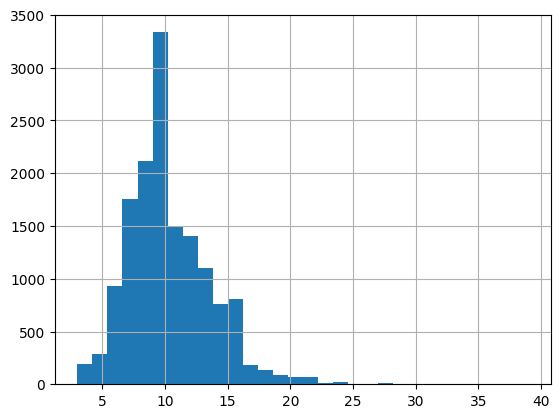

In [142]:
clean_df['name'].str.len().describe()
clean_df['name'].str.len().hist(bins=30)

In [133]:
clean_df['name'].str.len().quantile([0.90, 0.95, 0.99])

0.90    14.0
0.95    16.0
0.99    20.0
Name: name, dtype: float64

In [45]:
# Step 4: Create and train the model
import time
model = create_onehot_basic_classification_model(input_shape=[X_train.shape[1]],num_classes=len(df['SR_Name'].unique()), )
start_time = time.time()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop],verbose=0)
end_time = time.time()
baseline_training_duration = end_time - start_time
print(f"\nTraining time: {baseline_training_duration:.2f} seconds")


test_results = evaluate_classification_model(model, X_test, y_test, './data', prefix="baeline_test", label_encoder=le)
train_results = evaluate_classification_model(model, X_train, y_train, './data', prefix="baeline_train",label_encoder=le)
print(test_results['accuracy'])
print(train_results['accuracy'])


Training time: 26.82 seconds


c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


label map: {0: 'Ayeyarwady', 1: 'Bago (East)', 2: 'Bago (West)', 3: 'Chin', 4: 'Kachin', 5: 'Kayah', 6: 'Kayin', 7: 'Magway', 8: 'Mandalay', 9: 'Mon', 10: 'Nay Pyi Taw', 11: 'Rakhine', 12: 'Sagaing', 13: 'Shan (East)', 14: 'Shan (North)', 15: 'Shan (South)', 16: 'Tanintharyi', 17: 'Yangon'}


c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


label map: {0: 'Ayeyarwady', 1: 'Bago (East)', 2: 'Bago (West)', 3: 'Chin', 4: 'Kachin', 5: 'Kayah', 6: 'Kayin', 7: 'Magway', 8: 'Mandalay', 9: 'Mon', 10: 'Nay Pyi Taw', 11: 'Rakhine', 12: 'Sagaing', 13: 'Shan (East)', 14: 'Shan (North)', 15: 'Shan (South)', 16: 'Tanintharyi', 17: 'Yangon'}
0.14899842448795858
0.14888074102663065


In [143]:
conv_model_ttok = create_conv_lstm_model(vocab_size_ttok, 25, len(clean_df['SR_Name'].unique()))
import time
start_time = time.time()
history = conv_model_ttok.fit(X_train_ttok, y_train_ttok, epochs=100, batch_size=32, validation_data=(X_test_ttok, y_test_ttok), callbacks=[early_stop],class_weight=class_weights_dict,verbose=0)
end_time = time.time()
conv_training_duration = end_time - start_time
print(f"\nTraining time: {conv_training_duration:.2f} seconds")


ttok_conv_test_results = evaluate_classification_model(conv_model_ttok, X_test_ttok, y_test_ttok, './data', prefix="ttok_conv_test")
ttok_conv_train_results = evaluate_classification_model(conv_model_ttok, X_train_ttok, y_train_ttok, './data', prefix="ttok_conv_train")
print(ttok_conv_test_results['accuracy'])
print(ttok_conv_train_results['accuracy'])


Training time: 63.17 seconds
0.1530497411658789
0.21420301042068698


In [48]:
lstm_model = create_simple_bilstm_model(vocab_size_char, max_len_char, len(label_encoder.classes_))
import time
start_time = time.time()
history = lstm_model.fit(X_train_char, y_train_char, epochs=100, batch_size=32, validation_data=(X_test_char, y_test_char),class_weight=class_weights,callbacks=[early_stop], verbose=0)
end_time = time.time()
lstm_training_duration = end_time - start_time
print(f"\nTraining time: {lstm_training_duration:.2f} seconds")


Training time: 257.81 seconds


In [50]:
simple_lstm_test_results = evaluate_classification_model(lstm_model, X_test_char, y_test_char, './data', prefix="simple_lstm_test")
simple_lstm_train_results = evaluate_classification_model(lstm_model, X_train_char, y_train_char, './data', prefix="simple_lstm_train")
print(simple_lstm_train_results['accuracy'])
print(simple_lstm_test_results['accuracy'])

0.39278131634819535
0.25367270242569184


In [67]:
ttok_lstm_model = create_simple_bilstm_model(vocab_size_ttok, max_len, len(label_encoder.classes_))
import time
start_time = time.time()
history = ttok_lstm_model.fit(X_train_ttok, y_train_ttok, epochs=100, batch_size=32, validation_data=(X_test_ttok, y_test_ttok),callbacks=[early_stop],class_weight=class_weights_dict, verbose=0)
end_time = time.time()
lstm_training_duration = end_time - start_time
print(f"\nTraining time: {lstm_training_duration:.2f} seconds")


Training time: 535.38 seconds


In [68]:
ttok_lstm_test_results = evaluate_classification_model(ttok_lstm_model, X_test_ttok, y_test_ttok, './data', prefix="ttok_lstm_test")
ttok_lstm_train_results = evaluate_classification_model(ttok_lstm_model, X_train_ttok, y_train_ttok, './data', prefix="ttok_lstm_train")
print(ttok_lstm_test_results['accuracy'])
print(ttok_lstm_train_results['accuracy'])

0.20447557225828494
0.28120653049271543


In [90]:
deep_lstm_model = create_deep_lstm_model(vocab_size_ttok, 50, len(clean_df['SR_Name'].unique()))
import time
start_time = time.time()
history = deep_lstm_model.fit(X_train_ttok, y_train_ttok, epochs=100, batch_size=32, validation_data=(X_test_ttok, y_test_ttok),callbacks=[early_stop],class_weight=class_weights_dict, verbose=0)
end_time = time.time()
lstm_training_duration = end_time - start_time
print(f"\nTraining time: {lstm_training_duration:.2f} seconds")


Training time: 939.63 seconds


In [92]:
ttok_deep_lstm_test_results = evaluate_classification_model(deep_lstm_model, X_test_ttok, y_test_ttok, './data', prefix="ttok_deep_lstm_test")
ttok_deep_lstm_train_results = evaluate_classification_model(deep_lstm_model, X_train_ttok, y_train_ttok, './data', prefix="ttok_deep_lstm_train")
ttok_deep_lstm_test_results['accuracy']
ttok_deep_lstm_train_results['accuracy']

c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

0.1959958836186734

In [93]:
print(ttok_deep_lstm_test_results['accuracy'])
print(ttok_deep_lstm_train_results['accuracy'])

0.13075747653350797
0.1959958836186734


In [ ]:
X_train_char, X_test_char, y_train_char, y_test_char, vocab_size_char = prepare_tokenizer_and_data(new_df, char_level=True)
adv_lstm_model = create_advanced_lstm_model(vocab_size_char, 20, len(new_df['SR_Name'].unique()))
import time
start_time = time.time()
history = adv_lstm_model.fit(X_train_char, y_train_char, epochs=50, batch_size=32, validation_data=(X_test_char, y_test_char), verbose=0)
end_time = time.time()
lstm_training_duration = end_time - start_time
print(f"\nTraining time: {lstm_training_duration:.2f} seconds")

Vocab size: 47
sequences: 19513
X_train shape: (13659, 20)
X_test shape: (5854, 20)
y_train shape: (13659,)
y_test shape: (5854,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 64)            3008      
                                                                 
 bidirectional_1 (Bidirecti  (None, 20, 128)           66048     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 20, 64)            41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0

In [ ]:

adv_lstm_test_results = evaluate_classification_model(adv_lstm_model, X_test_char, y_test_char, './data', prefix="adv_lstm_test")
adv_lstm_train_results = evaluate_classification_model(adv_lstm_model, X_train_char, y_train_char, './data', prefix="adv_lstm_train")

c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

In [ ]:
lstm_model = create_simple_bilstm_model(vocab_size_char, 20, len(new_df['SR_Name'].unique()))
import time
start_time = time.time()
history = lstm_model.fit(X_train_char, y_train_char, epochs=50, batch_size=32, validation_data=(X_test_char, y_test_char), verbose=0)
end_time = time.time()
lstm_training_duration = end_time - start_time
print(f"\nTraining time: {lstm_training_duration:.2f} seconds")


Training time: 475.58 seconds


In [ ]:
lstm_test_results = evaluate_classification_model(lstm_model, X_test_char, y_test_char, './data', prefix="lstm_test")
lstm_train_results = evaluate_classification_model(lstm_model, X_train_char, y_train_char, './data', prefix="lstm_train")

In [68]:
#print(tokenizer.word_index)
import time
fourhl_model = create_model_with_four_HL(input_shape=[X_train.shape[1]],num_classes=len(df['SR_Name'].unique()))
start_time = time.time()
history = fourhl_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stop], verbose=0)
end_time = time.time()
baseline_training_duration = end_time - start_time
print(f"\nTraining time: {baseline_training_duration:.2f} seconds")


Training time: 108.57 seconds


In [ ]:
fourHL_test_results = evaluate_classification_model(fourhl_model, X_test, y_test, './data', prefix="4HL_test")
fourHL_train_results = evaluate_classification_model(fourhl_model, X_train, y_train, './data', prefix="4HL_train")
print(fourHL_test_results['accuracy'])
print(fourHL_train_results['accuracy'])

In [79]:
import time
deepdense_model = create_deep_dense_model(input_shape=[X_train.shape[1]],num_classes=len(df['SR_Name'].unique()))
start_time = time.time()
history = deepdense_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[early_stop], verbose=0)
end_time = time.time()
baseline_training_duration = end_time - start_time
print(f"\nTraining time: {baseline_training_duration:.2f} seconds")


Training time: 403.05 seconds


In [80]:
deepdense_test_results = evaluate_classification_model(deepdense_model, X_test, y_test, './data', prefix="deepdense_test")
deepdense_train_results = evaluate_classification_model(deepdense_model, X_train, y_train, './data', prefix="deepdense_train")
print(deepdense_test_results['accuracy'])
print(deepdense_train_results['accuracy'])

c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nuwai\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\User

0.2210454390160574
0.4525953583717695


In [ ]:
# # Step 5: Evaluate the model

# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score

# y_pred = model.predict(X_test, batch_size=32, verbose=0)
# y_pred = y_pred.argmax(axis=1)
# report = classification_report(y_test, y_pred, output_dict=True)
# report_df = pd.DataFrame(report).round(2).transpose()
# report_df.to_csv('./data/cls_report_test.csv', index=False)

# y_pred = model.predict(X_train, batch_size=32, verbose=0)
# y_pred = y_pred.argmax(axis=1)
# report = classification_report(y_train, y_pred, output_dict=True)
# report_df = pd.DataFrame(report).round(2).transpose()
# report_df.to_csv('./data/cls_report_train.csv', index=False)